# PROPOSAL and EcoMug - underground water muography simulation

how to run the simulation:
1. configure the `config.py`
2. run in two seperate terminals:
* `dask scheduler`
* `dask worker localhost:8786` (important! run in `/computation`) 
* `dask worker localhost:8786 --nworkers 23 --nthreads 1 --memory-limit="4 GiB" --local-directory /tmp` (optimized for TU Dortmund phobos server)
3. continue with cells below


currently the ```config.py``` is set the same as in my bachelor thesis, except for the number of simulated muons (```STATISTICS```). This is set to 10k muons instead of 10 mio muons, for quicker execution times.
Furthermore the parameter ```v_cut``` from PROPOSAL is very time sensitive. (increase for quicker, but less accurate simulations of PROPOSAL)

In [1]:
# !mkdir data_hdf
# SET hdf_folder in config!

now you can run the next two cells where it first creates a file with all muons needed with EcoMug, then propagates them with PROPOSAL in the second cell

In [2]:
# dont forget to set the correct env variables!
# !export PYTHONPATH="$HOME/muography2/computation:$PYTHONPATH"
# !export LD_LIBRARY_PATH="/scratch/mschoenfeld/envs/muo_23/lib:$LD_LIBRARY_PATH"
# conda env config vars set PYTHONPATH="$HOME/muography2/computation/EcoMug_pybind11/build"
# conda env config vars set LD_LIBRARY_PATH="/scratch/mschoenfeld/envs/3.11/lib"

In [3]:
!python d_EM.py

/bin/bash: /scratch/mschoenfeld/envs/3.11/lib/libtinfo.so.6: no version information available (required by /bin/bash)
generating EcoMug_1e6_gaisser_min6e2_max3e5_60deg_3D_1.1.hdf
calculate muons with EcoMug took    36.4 s
Total time: 0.6 min


In [4]:
!python d_pp.py

/bin/bash: /scratch/mschoenfeld/envs/3.11/lib/libtinfo.so.6: no version information available (required by /bin/bash)
EcoMug_1e6_gaisser_min6e2_max3e5_60deg_3D_1.1.hdf | N_tasks = 23
PROPOSAL config = kirchhellen_AVG_3D_840m.json, vcut=0.001_Highland
propagating took   349.5 s
(317.0) of 1e+06 (0.0317)% detector hits | min(E_i) at detector = 789.2 GeV


# Muon spectra (EcoMug) plots

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from importlib import reload
import py_library.my_plots_library as plib
import py_library.stopwatch as stopwatch
import py_library.simulate_lib as slib
import config as config_file

# os.chdir(os.path.dirname(__file__))
reload(config_file)
reload(slib)
reload(plib)
reload(stopwatch)

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams.update({'figure.dpi':70})

df_EM = pd.read_hdf(config_file.hdf_folder+config_file.file_name, key='main')

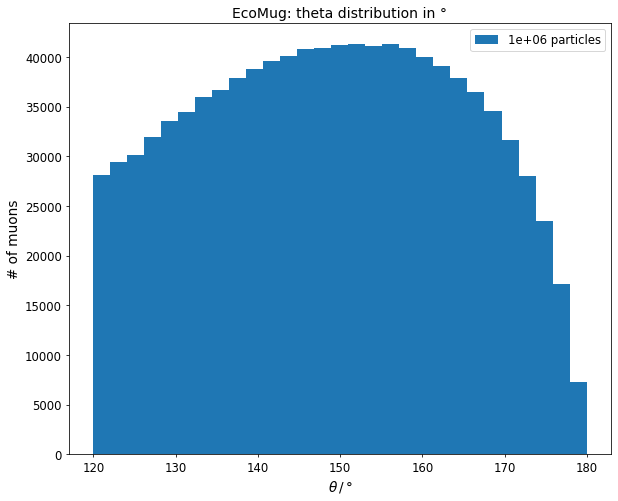

In [6]:
# EcoMug: theta distribution in °
plib.plot_hist(
    np.degrees(df_EM['theta']), 
    name='EcoMug: theta distribution in °',
    ylabel = '# of muons',
    xlabel1 = r'\theta',
    xlabel2 = '°',
    xlog=False,
    binsize=30,
    show_or_multiplot=config_file.show_or_multiplot,
    savefig=True)

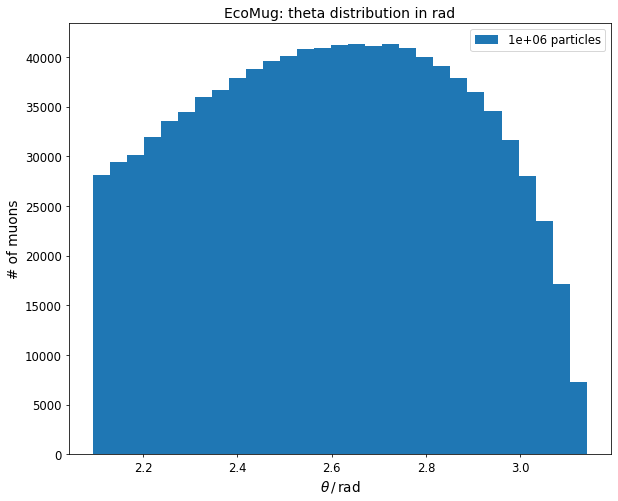

In [7]:
# EcoMug: theta distribution in rad
plib.plot_hist(
    df_EM['theta'], 
    name='EcoMug: theta distribution in rad',
    ylabel = '# of muons',
    xlabel1 = r'\theta',
    xlabel2 = 'rad',
    xlog=False,
    binsize=30,
    show_or_multiplot=config_file.show_or_multiplot,
    savefig=True)

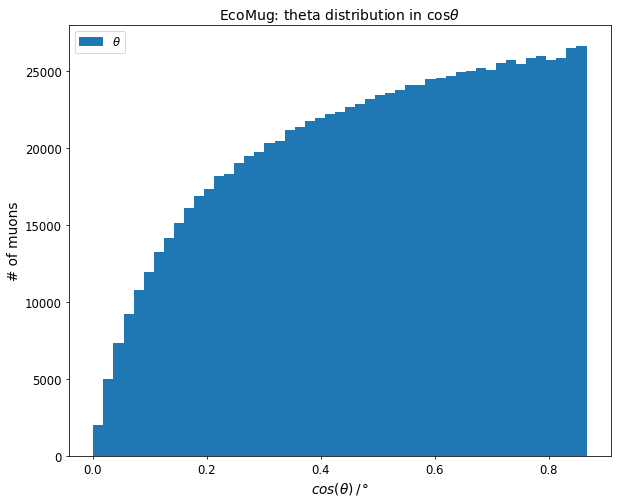

In [8]:
# EcoMug: theta distribution in cos(theta)
a = 1/2*np.pi - df_EM['theta']
plib.plot_hist(
    np.cos(a), 
    ylabel='# of muons',
    xlabel1=r'cos(\theta)',
    xlabel2='°',
    name=r'EcoMug: theta distribution in cos$\theta$',
    label=r'$\theta$',
    xlog=False,
    binsize=50,
    show_or_multiplot=True,
    savefig=True)

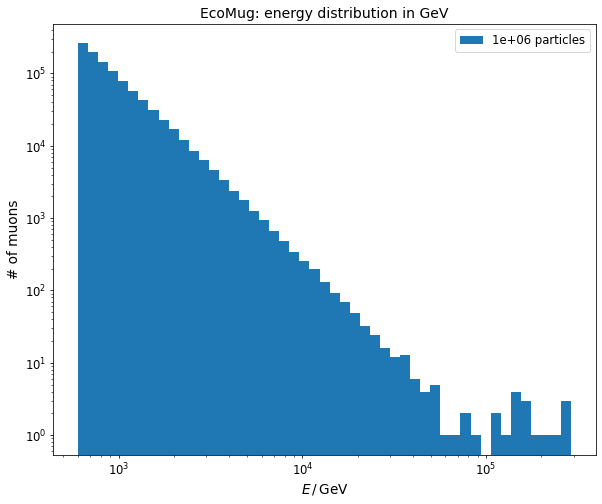

In [9]:
# EcoMug: energy distribution
plib.plot_hist(
    df_EM['energy'], 
    name='EcoMug: energy distribution in GeV',
    ylabel = '# of muons',
    xlabel1 = 'E',
    xlabel2 = 'GeV',
    xlog=True,
    binsize=50,
    show_or_multiplot='show',
    savefig=True)

myons with more than 600 GeV = 1000000 (100.00%)


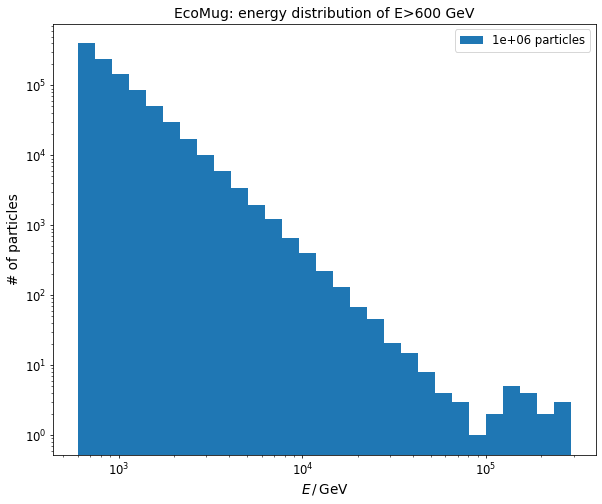

In [10]:
# looking how many muons are over energy_threshold for setting the energy threshold
energy_threshold = 600  # GeV
a = []
for i in df_EM['energy']:
    if (i>energy_threshold):
        a.append(i)

len_a = len(a)
print(f'myons with more than {energy_threshold} GeV = {len_a} ({len_a/config_file.STATISTICS*100:.2f}%)')
if len_a > 100:
    plib.plot_hist(
        a, 
        name=f'EcoMug: energy distribution of E>{energy_threshold} GeV',
        xlabel1 = 'E',
        xlabel2 = 'GeV',
        show_or_multiplot=config_file.show_or_multiplot,
        xlog=True
    )


# PROPOSAL Plots

In [11]:
df_pp = pd.read_hdf(config_file.hdf_folder+config_file.file_name_results, key='main')

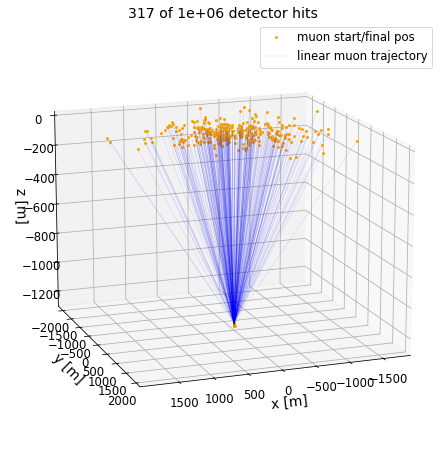

In [12]:
# 3D plot
counter = len(df_pp['point1x'])
if (counter>2000):
    end = 2000
else:
    end = counter

start_points = np.zeros(shape=(counter, 3), dtype=np.float64)
end_points = np.zeros(shape=(counter, 3), dtype=np.float64)
start_end_points = np.zeros(shape=(counter*2, 3), dtype=np.float64)

for i in range(end):
    start_points[i] = [df_pp['point1x'][i], df_pp['point1y'][i], df_pp['point1z'][i]]
    end_points[i] = [df_pp['point2x'][i], df_pp['point2y'][i], df_pp['point2z'][i]]
    start_end_points[i*2] = start_points[i]
    start_end_points[i*2+1] = end_points[i]

plib.plot_3D_start_end(
    start_end_points/100,
    elev=15, azim=70, alpha=0.14, dpi=1, show=config_file.show_plots,
    title=f'{counter} of {config_file.STATISTICS:.0e} detector hits'
)

In [ ]:
# 3D plot end points close up look

# counter = len(df_pp['point1x'])
# if (counter>2000):
#     end = 2000
# else:
#     end = counter

# end_points = np.zeros(shape=(counter, 3), dtype=np.float64)

# for i in range(end):
#     end_points[i] = [df_pp['point2x'][i], df_pp['point2y'][i], df_pp['point2z'][i]]

# plib.plot_3D_start_end(
#     end_points/100,
#     elev=15, azim=70, alpha=0.14, dpi=1, show=config_file.show_plots,
#     title=f'end points close up look'
# )

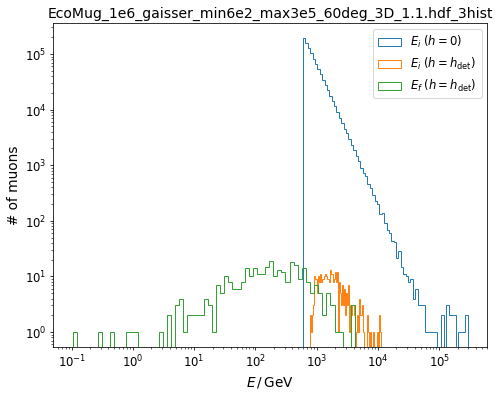

In [15]:
plt.rcParams['figure.figsize'] = (8, 6)
# Initial energy of the muons (blue)
plib.plot_hist(
    df_EM['energy'], 
    label=r'$E_i \;(h=0)$',
    binsize=70,
    xlog=True,
    show_or_multiplot='multi',
    histtype='step'
)
# Initial energy of the muons that arrived at the detector (orange)
bins_energies_i = plib.plot_hist(
    df_pp['energies_i']/1000, 
    label=r'$E_i \;(h=h_{\mathrm{det}})$',
    xlog=True,
    binsize=70,
    show_or_multiplot='multi',
    histtype='step'
)
# Final energy of the muons that arrived at the detector (orange)
plib.plot_hist(
    df_pp['energies_f']/1000, 
    name=f'{config_file.file_name}_3hist',
    ylabel = '# of muons',
    xlabel1 = 'E',
    xlabel2 = 'GeV',
    label=r'$E_f \;(h=h_{\mathrm{det}})$',
    show_or_multiplot='show',
    xlog=True,
    binsize=70,
    savefig=True,
    histtype='step'
)

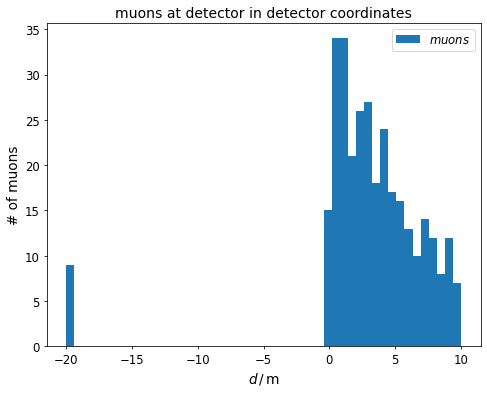

In [16]:
# muons at detector in detector coordinates
a = (df_pp['point2z'] - (config_file.detector_pos[2] - config_file.detector_height/2))/100
plib.plot_hist(
    a,
    ylabel = '# of muons',
    xlabel1 = 'd',
    xlabel2 = 'm',
    label=r'$muons$',
    name='muons at detector in detector coordinates',
    xlog=False,
    binsize=50,
    histtype='bar'
)

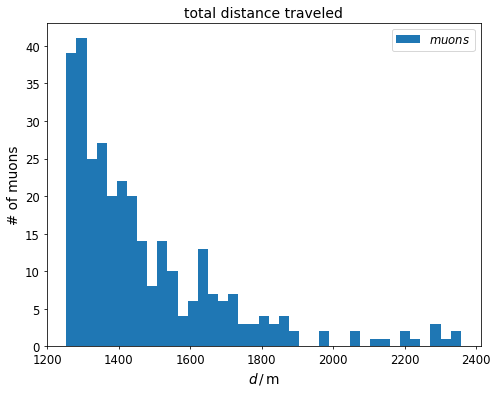

In [17]:
# total distance traveled
plib.plot_hist(
    df_pp['distances']/100, 
    name='total distance traveled',
    ylabel = '# of muons',
    xlabel1 = 'd',
    xlabel2 = 'm',
    label=r'$muons$',
    xlog=False,
    binsize=40,
    savefig=True,
    histtype='bar'
)

# Result plot

To create the result-plot, you need to simulate each "water depth" separately.
Then you need to write the results into ```results-counts.txt```. 
Format: 
This is read by the following code and the results plot can be created.

Currently ```results-counts.txt``` hold my bachelors results.
To verify my results you can check the 

In [18]:
# calculate a muon flux of a given detector at sea level (using gaisser function)
from scipy.integrate import tplquad
from uncertainties import ufloat
reload(config_file)

emin = float(config_file.min_E)
emax = float(config_file.max_E)
thetamin = float(config_file.min_theta)
thetamax = float(config_file.max_theta)

# emin = 1e
# emax = 1e2
# thetamin = 0
# thetamax = 90

scale_factor = 1e0  # adjustment for better numeric performance

f = lambda theta, phi, E: 0.14*E**(-2.7)*(
                    1    /(1 + 1.1 * E * np.cos(theta) / (115))
                  + 0.054/(1 + 1.1 * E * np.cos(theta) / (850))
                )*scale_factor 

muons_per_x = tplquad(f,
    emin                               , int(emax),
    lambda E: 0                        , lambda E: 2*np.pi,
    lambda E, phi: np.radians(thetamin), lambda E, phi: np.radians(thetamax)
    )

print(f'{muons_per_x[0]*1e4:.3} Muons per second per m^2 (should be around 100 for full integration limits)')

detector_area = config_file.artificial_detector_area
muon_rate = muons_per_x[0]*60*60*24*detector_area
muon_rate_u = ufloat(muon_rate, muons_per_x[1])/scale_factor

# print(f'{muons_per_x[0]/scale_factor} +- {muons_per_x[1]/scale_factor} / 1/cm^2*min')
print(f'{muon_rate_u:.3f} Muons per Day for artificial detector surface (with numerical error)')


# (633.0) of 1e+06 (0.0633)% detector hits | min(E_i) at detector = 709.9 GeV
percent_of_muons_arrived = 0.00059
percent_of_muons_arrived = 0.00067  # from meeting (wrong ecomug distribution, error in formula)
percent_of_muons_arrived = len(df_pp['point1x'])/config_file.STATISTICS
print(f'{muon_rate*percent_of_muons_arrived:.1f} Muons per Day (The real detectorrate!)')
# muon_rate * percent_of_muons_arrived/config_file.calibrate_which_get_detected



0.0148 Muons per second per m^2 (should be around 100 for full integration limits)
1204504.079+/-0.000 Muons per Day for artificial detector surface (with numerical error)
381.8 Muons per Day (The real detectorrate!)


In [19]:
# The results plot... needs some work to make it more automatic and do the actual simulations

# from numpy import loadtxt
# from uncertainties import unumpy

# results = loadtxt('results-counts.txt', delimiter=';')

# depth = results[:,1]
# counts = results[:,0]
# # STATISTICS = config_file.STATISTICS
# STATISTICS = 1e7  # bachelor thesis results value
# # counts_err = unumpy.uarray(counts, np.sqrt(counts))
# # detektorrate = muon_rate*counts_err/STATISTICS
# detektorrate = muon_rate*counts/STATISTICS

# plt.style.use('seaborn-whitegrid')
# # plt.errorbar(
# #     depth, unumpy.nominal_values(detektorrate), 
# #     yerr=unumpy.std_devs(detektorrate), fmt='vr', label='simulation data')
# plt.scatter(
#     depth, detektorrate, label='simulation data')
# plt.ylabel('counts per day')
# plt.xlabel('water depth')
# plt.legend()
# # plt.savefig('results_plot.pdf', dpi=1000)

# calculate measurement time
please see ```detector_precision.ipynb```.